# LIBRARY

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


# SELECT THE DATA

In [38]:
file_path = 'Input_data_timeseries (version 1).xlsx'  # Replace with your file's path
data = pd.read_excel(file_path)
display(data)

,ROUTE,ORDER DATE,NUMBER OF ACTUAL ORDERS
0,BELGIUM__BELGIUM,2022-12-13,4
1,BELGIUM__BELGIUM,2022-12-13,1
2,BELGIUM__BELGIUM,2022-12-13,7
3,BELGIUM__BELGIUM,2022-12-13,19
4,BELGIUM__BELGIUM,2022-12-13,22
...,...,...,...
170027,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170028,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170029,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170030,NaN,NaT,772574


# ALL THE POSSIBLE ROUTE WITH THE SUM OF ORDER PER DAY

we know that for each route we have to take the order from 5 different company in one day, we have decide to sum all the order per day from the different comany

_____inseire eempio

In [39]:
pv_all_route = pd.pivot_table(data, index=['ORDER DATE'], columns=['ROUTE'], values='NUMBER OF ACTUAL ORDERS', aggfunc = 'sum')
display(pv_all_route)


ROUTE,BELGIUM__BELGIUM,BELGIUM__EAST_BALCAN,BELGIUM__GERMANY_RUHR,BELGIUM__GREAT_BRITAIN,BELGIUM__ITALY_NORTH_EAST_CENTER,BELGIUM__ITALY_NORTH_WEST,BELGIUM__ITALY_SOUTH,BELGIUM__ROMANIA,BELGIUM__SCANDINAVIA,EAST_BALCAN__BELGIUM,...,ITALY_SOUTH__ITALY_SOUTH,ITALY_SOUTH__SCANDINAVIA,ROMANIA__BELGIUM,ROMANIA__GERMANY_RUHR,ROMANIA__GREAT_BRITAIN,ROMANIA__ITALY_NORTH_WEST,SCANDINAVIA__BELGIUM,SCANDINAVIA__ITALY_NORTH_EAST_CENTER,SCANDINAVIA__ITALY_NORTH_WEST,SCANDINAVIA__ITALY_SOUTH
ORDER DATE,,,,,,,,,,,,,,,,,,,,,
2022-01-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,20,0,0
2022-01-02,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,3,12,0,5,0,0
2022-01-03,50,10,8,36,8,4,5,10,0,14,...,29,19,70,25,17,68,7,17,11,11
2022-01-04,41,13,13,51,8,14,8,19,10,14,...,39,33,78,29,41,75,7,13,7,12
2022-01-05,49,15,16,55,13,0,5,18,11,14,...,36,23,86,37,48,72,5,19,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-09,51,24,18,31,23,8,23,29,10,34,...,49,18,63,26,44,58,8,9,8,15
2022-12-10,5,0,1,2,1,1,0,2,1,1,...,2,0,11,0,0,25,0,5,0,0
2022-12-11,0,0,0,0,0,0,0,1,2,1,...,1,0,7,0,1,18,0,5,0,0


# EDA

check null value, possible NAN or error in the dataset

In [40]:
#check info
pv_all_route.info()
#check null values
pv_all_route.isna().sum()
#le ultime due righe anno i valori nulli, semprano dei totali,
#uno è totale di ordini, l'altro non so!!(CHIEDERE!!)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 2022-01-01 to 2022-12-13
Data columns (total 98 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   BELGIUM__BELGIUM                                  347 non-null    int64
 1   BELGIUM__EAST_BALCAN                              347 non-null    int64
 2   BELGIUM__GERMANY_RUHR                             347 non-null    int64
 3   BELGIUM__GREAT_BRITAIN                            347 non-null    int64
 4   BELGIUM__ITALY_NORTH_EAST_CENTER                  347 non-null    int64
 5   BELGIUM__ITALY_NORTH_WEST                         347 non-null    int64
 6   BELGIUM__ITALY_SOUTH                              347 non-null    int64
 7   BELGIUM__ROMANIA                                  347 non-null    int64
 8   BELGIUM__SCANDINAVIA                              347 non-null    int64
 9   EAST_BALCAN__BELGIUM    

ROUTE
BELGIUM__BELGIUM                        0
BELGIUM__EAST_BALCAN                    0
BELGIUM__GERMANY_RUHR                   0
BELGIUM__GREAT_BRITAIN                  0
BELGIUM__ITALY_NORTH_EAST_CENTER        0
                                       ..
ROMANIA__ITALY_NORTH_WEST               0
SCANDINAVIA__BELGIUM                    0
SCANDINAVIA__ITALY_NORTH_EAST_CENTER    0
SCANDINAVIA__ITALY_NORTH_WEST           0
SCANDINAVIA__ITALY_SOUTH                0
Length: 98, dtype: int64

In [41]:
#index
display(pv_all_route.index)
print(type(pv_all_route.index[0]))
#i try to select only one route
display(pv_all_route['BELGIUM__BELGIUM'])

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-04', '2022-12-05', '2022-12-06', '2022-12-07',
               '2022-12-08', '2022-12-09', '2022-12-10', '2022-12-11',
               '2022-12-12', '2022-12-13'],
              dtype='datetime64[ns]', name='ORDER DATE', length=347, freq=None)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


ORDER DATE
2022-01-01     1
2022-01-02     0
2022-01-03    50
2022-01-04    41
2022-01-05    49
              ..
2022-12-09    51
2022-12-10     5
2022-12-11     0
2022-12-12    54
2022-12-13    53
Name: BELGIUM__BELGIUM, Length: 347, dtype: int64

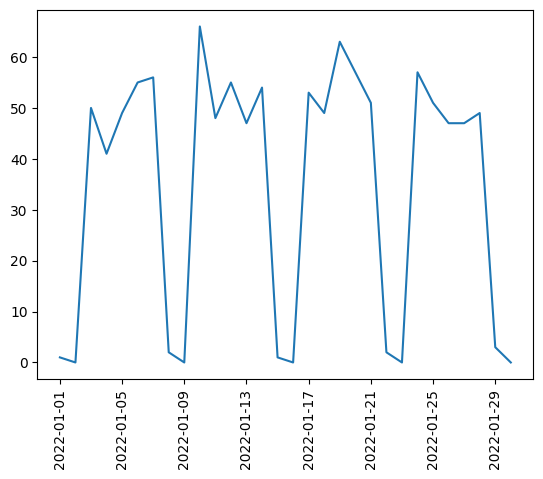

In [42]:
#plot only one month for the route BELGIUM_BELGIUM
plt.plot(pv_all_route.loc['2022-01-01':'2022-01-30','BELGIUM__BELGIUM'])
plt.xticks(rotation=90)
plt.show()

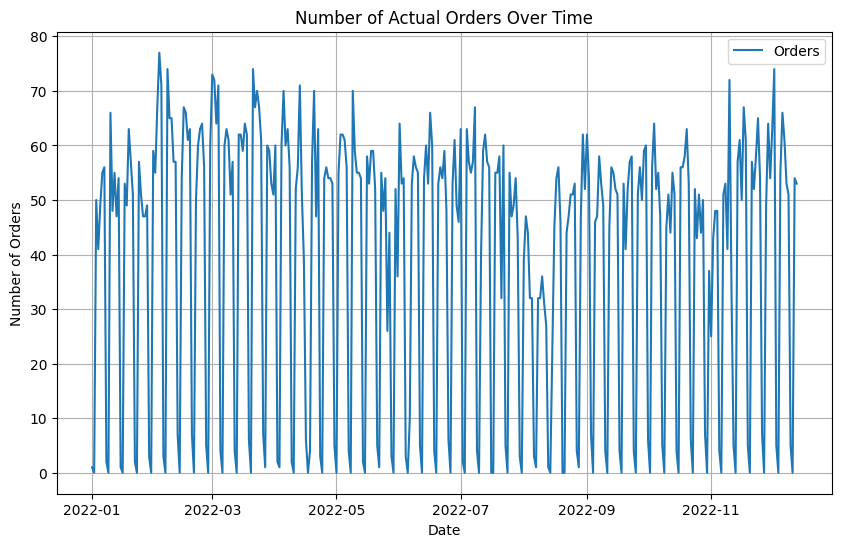

In [43]:
#plot all the year
plt.figure(figsize=(10, 6))
plt.plot(pv_all_route.index, pv_all_route['BELGIUM__BELGIUM'], label='Orders')
plt.title('Number of Actual Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid()
plt.show()

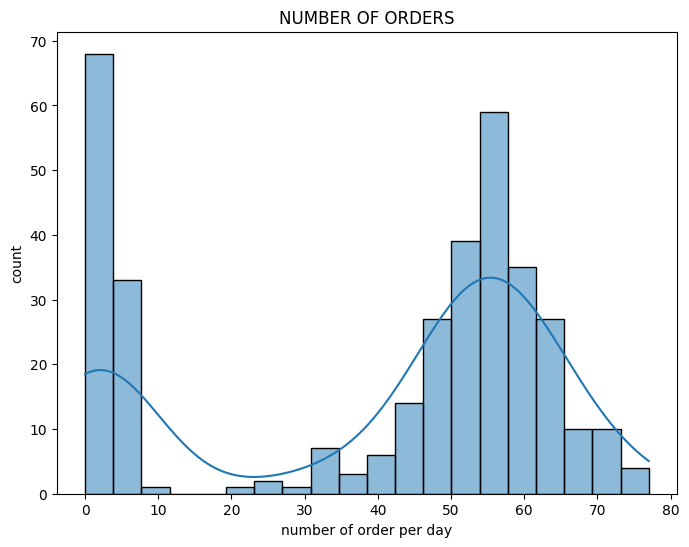

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
s_feature = sns.histplot(pv_all_route['BELGIUM__BELGIUM'], bins=20, kde=True,ax = ax)
s_feature.set_title('NUMBER OF ORDERS')
s_feature.set_xlabel('number of order per day')
s_feature.set_ylabel('count')
plt.show()


# PASSAGE FOR FORECASTING


-   Check for stationarity of the data
-   Determine the seasonality of the data
-   Make the data stationary by applying differenciation
-   Perform ACF and PACF analysis to gather the parameters for the model part
-   Train the models and get the predictions
-   Compare the models used by MAE and MSE and AIC

To determine if our data is stationary or not we have to use the KPSS and the ADFuller tests which have different hypothesis and can be done separated.

Also we have to apply the forecasting for the next week and for all the possible route, probably we have to apply a loop in the columns

## CHECK STATIONARITY

To check the stationarity we can use two method: ADF and KPSS

We will apply all the methos

### ADF

In [45]:
#Execute an AdFuller test on the data. If the p-value is less than <=0.05 the data is stationary, otherwise it is not.
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

### KPSS

In [46]:
def kpss_test(data):
  #kpss_out = kpss(data,regression='ct', nlags='auto', store=True) #i have a warning becouse my test statistic is extrimely small 
  #so i use a different configuration for the KPSS
  kpss_out = kpss(data,regression='c', nlags=20, store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

Remember

Important Note: These two tests are not interchangeble, considering their different assumptions/null hypotheses. It is always better to apply both of them, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:
-   Case 1: Both tests conclude that the series is not stationary - The series is not stationary.

-   Case 2: Both tests conclude that the series is stationary - The series is stationary.

-   Case 3: KPSS indicates stationarity and ADF indicates non-stationarity -> The series is trend stationary: it requires operations to remove the trend. The resulting detrended series is checked for stationarity.

-   Case 4: KPSS indicates non-stationarity and ADF indicates stationarity -> The series is difference stationary: it requires differencing. The differenced series is checked for stationarity.

## SEASONALITY OF THE DATASET

## DIFFERENTIATION

In [47]:
# first test to de trend it is the differencing, after check the kpss and adf in 
#case apply again differencing!!

def differencing(data):
    #first order differencing
    detrended_data = data.diff().dropna()
    #plot the detrended data
    plt.figure(figsize=(10, 6))
    plt.plot(detrended_data, label="Detrended Data")
    plt.title("Detrended Time Series (First-Order Differencing)")
    plt.legend()
    plt.show()

    return detrended_data

#   CAPIRE SE CE DA AGGIUNGERE ANCHE IL RESAMPLE OF THE DATA AFTER FIFFERENTIATION

## FIND THE BEST PARAMETER

### AUTOCORRELATION FUNCTION (ACF)

In [48]:
def acf(data):
    plt.figure(figsize=(12,6))
    plot_acf(data, lags=30, ax=plt.subplot(121))
    plt.show()

### PARTIAL AUTOCORRELATION FUNCTION (PACF)

In [49]:
def pacf(data):
    plt.figure(figsize=(12, 6))
    plot_pacf(data, lags=30, ax=plt.subplot(122))
    plt.show()

### GRID SEARCH

Now we test a searies of possible value for p,d,q (parameter for ARIMA) and we wnat to find the best one

In [50]:
#use a range of possible values for p,d, and q, and evaluate each combination

def best_parameters(data): #maybe also add the parameter max limit for p,d,q

    warnings.filterwarnings("ignore")  # To suppress convergence warnings

    # Define the range for p, d, q
    p = range(0, 5)  # Test values for AR terms
    d = range(0, 2)  # Test values for differencing
    q = range(0, 5)  # Test values for MA terms

    # Track the best combination
    best_aic = float("inf")
    best_order = None
    results = []

    # Perform grid search
    for i in p:
        for j in d:
            for k in q:
                try:
                    # Fit ARIMA model
                    model = ARIMA(data, order=(i, j, k)) #IF NOT APPLY THE DIFFERENTIATION USE THE NORMAL TRAIN
                    model_fit = model.fit()
                    
                    # Record the AIC value
                    aic = model_fit.aic
                    results.append(((i, j, k), aic))
                    
                    # Update best model
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (i, j, k)
                except:
                    continue

    # Display the best order
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order

## CREATE THE MODEL

In [51]:
def define_model(data, best_order):

    # Fit the best ARIMA model
    best_model = ARIMA(data, order=best_order)
    best_model_fit = best_model.fit()

    # Display the summary
    print(best_model_fit.summary())

    best_model_fit.plot_diagnostics(figsize=(20,15))
    
    return best_model_fit

### DURBIN WATSON

In [52]:
def test_durbin(best_model_fit):
    print('Durbin watson: ',durbin_watson(best_model_fit.resid))

### JUNGBOX

In [53]:
def test_jungbox(best_model_fit):
    # H0: The residuals are independently distributed.
    # H1: The residuals are not independently distributed; they exhibit serial correlation
    ljung_test = acorr_ljungbox(best_model_fit.resid)
    display(ljung_test.head())

## FORECASTING

In [54]:
def try_forecast(data, best_model_fit):
    # Forecast the next 7 days (or adjust the 'steps' based on the length of your test set)
    forecast_steps = len(data)  # Number of points in your test set
    #forecast_steps = 7
    forecast = best_model_fit.forecast(steps=forecast_steps)

    #or try to use get_prediction!!
    #prediction = best_model_fit.get_prediction(start=test.index[0], end=test.index[-1])
    #forecast = prediction.summary_frame()

    forecast.index = data.index  # Match the index of the test set for easy comparison

    # Print forecasted values
    print("Forecasted values:\n", forecast)
    return forecast


In [55]:
def validate(data, forecast):
    # try to validate
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(data['NUMBER OF ACTUAL ORDERS'], forecast))
    mae = mean_absolute_error(data['NUMBER OF ACTUAL ORDERS'], forecast)

    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")


In [56]:
def plot_validation(train, test, forecast):
    # Plot actual vs forecast
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train['NUMBER OF ACTUAL ORDERS'], label='Train Data', color='blue')
    plt.plot(test.index, test['NUMBER OF ACTUAL ORDERS'], label='Test Data (Actual)', color='green')
    #plt.plot(forecast.index, forecast, label='Forecasted Data', color='red', linestyle='--')
    plt.plot(forecast.index, forecast, label='Forecasted Data', color='red', linestyle='--')
    #plt.plot(forecast['mean'], label='Forecasted Data', color='red', linestyle='--')
    #plt.plot(val.index, val, label='val', color='yellow')
    #plt.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
    plt.legend()
    plt.title("ARIMA Forecast vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Number of Orders")
    plt.show()

    # Plot actual vs forecast (tutto diff()?????) #a senso è meglio farlo per tutti i valor e poi fare forecast e modello???



# MAIN